In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
import rioxarray as rio

In [2]:
# Load plot locations

PLOT_COORDS_FPATH = 'data/SPL2018_EFI_ground_plots/SPL2018_EFI_ground_plots/PRF_SPL2018_EFI_plots_pts_wgs84.shp'

LABELS_FPATH = 'data/labels.csv'

ALS_METRICS_FPATH = r'data/als_metrics.tif'

plots_gdf = gpd.read_file(PLOT_COORDS_FPATH).rename(columns={"Plot": "plot_id"})

labels_df = pd.read_csv(LABELS_FPATH)

plots_gdf

,plot_id,Date,Northing,Easting,Source,geometry
0,PRF208R,August 7 2018,5098426.096,312924.933,Topcon Hiper V PPP,POINT Z (312924.734 5098427.112 0)
1,PRF320,November 23 2018,5098579.361,312625.094,Topcon HiperSR PPP,POINT Z (312624.895 5098580.377 0)
2,PRF016,August 8 2018,5096992.483,313662.119,Topcon Hiper V PPP,POINT Z (313661.921 5096993.499 0)
3,PRF017,August 14 2018,5096896.098,313863.850,Topcon Hiper V PPP,POINT Z (313863.652 5096897.114 0)
4,PRF018,August 8 2018,5097138.299,313692.563,Topcon Hiper V PPP,POINT Z (313692.365 5097139.315 0)
...,...,...,...,...,...,...
244,PRF187,November 22 2018,5091476.078,308950.650,Topcon Hiper V PPP,POINT Z (308950.451 5091477.093 0)
245,PRF209,October 19 2018,5091851.419,312997.322,Topcon Hiper V PPP,POINT Z (312997.124 5091852.434 0)
246,PRF214,October 6 2018,5091627.257,312973.063,Topcon Hiper V PPP,POINT Z (312972.865 5091628.272 0)
247,PRF149,October 25 2018,5090277.081,301422.935,Topcon HiperSR PPP,POINT Z (301422.735 5090278.095 0)


In [3]:
als_metrics = rio.open_rasterio(ALS_METRICS_FPATH)
als_metrics

<xarray.DataArray (band: 67, y: 366, x: 746)> Size: 73MB
[18293412 values with dtype=float32]
Coordinates:
  * band         (band) int64 536B 1 2 3 4 5 6 7 8 9 ... 60 61 62 63 64 65 66 67
  * y            (y) float64 3kB 5.099e+06 5.099e+06 ... 5.09e+06 5.09e+06
  * x            (x) float64 6kB 2.974e+05 2.974e+05 ... 3.16e+05 3.16e+05
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -3.4028235e+38
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('avg_95', 'avg', 'b10', 'b20', 'b30', 'b40', 'b50', 'b60...

Ensure that raster and plot coordinates are in the same CRS.

In [4]:
assert plots_gdf.crs == als_metrics.rio.crs, "CRS mismatch between plots and raster data."

Convert ALS metric names from a tuple to a list for later use.

In [5]:
als_metrics_nms = list(als_metrics.long_name)

In [6]:
plot_coords = [(geom.x, geom.y) for geom in plots_gdf.geometry]

for i, metric in enumerate(als_metrics_nms):

    print(f"Extracting metric: {metric}")

    metric_ras_i = als_metrics[i]
    plots_gdf[metric] = [float(metric_ras_i.sel(x=c[0], y=c[1], method="nearest").values) for c in plot_coords]

Extracting metric: avg_95
Extracting metric: avg
Extracting metric: b10
Extracting metric: b20
Extracting metric: b30
Extracting metric: b40
Extracting metric: b50
Extracting metric: b60
Extracting metric: b70
Extracting metric: b80
Extracting metric: b90
Extracting metric: dns_10m
Extracting metric: dns_12m
Extracting metric: dns_14m
Extracting metric: dns_15m
Extracting metric: dns_16m
Extracting metric: dns_18m
Extracting metric: dns_20m
Extracting metric: dns_25m
Extracting metric: dns_2m
Extracting metric: dns_4m
Extracting metric: dns_5m
Extracting metric: dns_6m
Extracting metric: dns_8m
Extracting metric: kur_95
Extracting metric: p01
Extracting metric: p05
Extracting metric: p10
Extracting metric: p20
Extracting metric: p30
Extracting metric: p40
Extracting metric: p50
Extracting metric: p60
Extracting metric: p70
Extracting metric: p80
Extracting metric: p90
Extracting metric: p95
Extracting metric: p99
Extracting metric: qav
Extracting metric: skew_95
Extracting metric: d0_2

Lets view the distribution of the 99th height percentile, it looks normal.

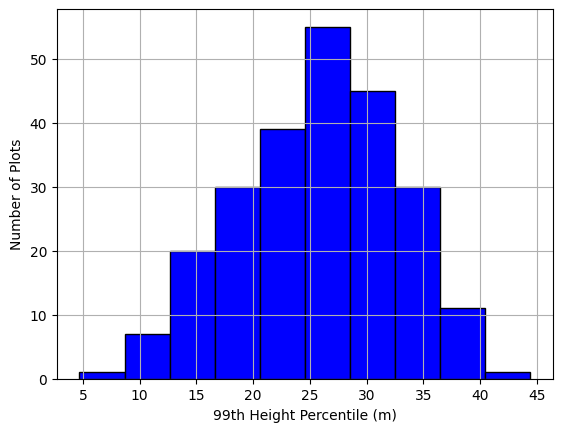

In [7]:
ax = plots_gdf['p99'].hist(edgecolor='black', color='blue')
ax.set_xlabel('99th Height Percentile (m)')
ax.set_ylabel('Number of Plots')
plt.show()

In [14]:
# Join metrics with labels
df = labels_df.merge(pd.DataFrame(plots_gdf), on='plot_id', how='left')

# Subset to plot_id, target, and als metrics
target_var = 'dom_sp_type'

df = df[['plot_id', 'split'] + [target_var] + als_metrics_nms]

# Check which ALS metric cols have NAs
na_counts = df.isna().sum()

# Print all cols with NAs
for col, na_count in na_counts.items():
    if na_count > 0:
        print(f"{col}: {na_count} NAs")

# Drop rows with any NAs
df = df.dropna()
df

avg_95: 10 NAs
avg: 10 NAs
b10: 10 NAs
b20: 10 NAs
b30: 10 NAs
b40: 10 NAs
b50: 10 NAs
b60: 10 NAs
b70: 10 NAs
b80: 10 NAs
b90: 10 NAs
dns_10m: 10 NAs
dns_12m: 10 NAs
dns_14m: 10 NAs
dns_15m: 10 NAs
dns_16m: 10 NAs
dns_18m: 10 NAs
dns_20m: 10 NAs
dns_25m: 10 NAs
dns_2m: 10 NAs
dns_4m: 10 NAs
dns_5m: 10 NAs
dns_6m: 10 NAs
dns_8m: 10 NAs
kur_95: 10 NAs
p01: 10 NAs
p05: 10 NAs
p10: 10 NAs
p20: 10 NAs
p30: 10 NAs
p40: 10 NAs
p50: 10 NAs
p60: 10 NAs
p70: 10 NAs
p80: 10 NAs
p90: 10 NAs
p95: 10 NAs
p99: 10 NAs
qav: 10 NAs
skew_95: 10 NAs
d0_2: 10 NAs
d10_12: 10 NAs
d12_14: 10 NAs
d14_16: 10 NAs
d16_18: 10 NAs
d18_20: 10 NAs
d20_22: 10 NAs
d22_24: 10 NAs
d24_26: 10 NAs
d26_28: 10 NAs
d28_30: 10 NAs
d2_4: 10 NAs
d30_32: 10 NAs
d32_34: 10 NAs
d34_36: 10 NAs
d36_38: 10 NAs
d38_40: 10 NAs
d40_42: 10 NAs
d42_44: 10 NAs
d44_46: 10 NAs
d46_48: 10 NAs
d4_6: 10 NAs
d6_8: 10 NAs
d8_10: 10 NAs
std_95: 10 NAs
vci_1mbin: 10 NAs
vci_0.5bin: 10 NAs


,plot_id,split,dom_sp_type,avg_95,avg,b10,b20,b30,b40,b50,...,d40_42,d42_44,d44_46,d46_48,d4_6,d6_8,d8_10,std_95,vci_1mbin,vci_0.5bin
1,PRF090,train,mixed,11.530000,12.460000,17.299999,20.199999,30.199999,52.500000,74.699997,...,0.0,0.0,0.0,0.0,1.4,4.2,7.3,6.69,0.84,0.84
2,PRF015,train,conif,14.910000,15.509999,11.599999,14.500000,22.600000,33.399998,39.200001,...,0.0,0.0,0.0,0.0,2.8,6.0,8.5,8.08,0.91,0.91
4,PRF208R,train,conif,2.240000,2.350000,12.300000,17.299999,23.100000,32.500000,45.399998,...,0.0,0.0,0.0,0.0,8.3,0.0,0.0,1.17,0.86,0.88
5,PRF324,train,conif,8.870000,9.550000,43.299999,47.500000,50.299999,51.799999,53.699997,...,0.0,0.0,0.0,0.0,2.5,1.8,1.4,8.84,0.73,0.76
6,PRF211,train,conif,9.410000,9.719999,7.000000,7.600000,8.500000,13.700000,23.699999,...,0.0,0.0,0.0,0.0,3.4,10.9,25.0,3.42,0.83,0.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,PRF212,test,mixed,16.100000,16.650000,13.700000,16.000000,18.699999,21.299999,24.000000,...,0.0,0.0,0.0,0.0,1.8,2.1,2.1,7.81,0.86,0.88
245,PRF049,test,mixed,2.100000,2.740000,67.699997,79.599998,83.599998,85.099998,86.000000,...,0.0,0.0,0.0,0.0,2.9,1.0,2.2,3.26,0.56,0.64
246,PRF161,test,decid,16.209999,16.510000,5.900000,6.300000,6.900000,7.900000,8.500000,...,0.0,0.0,0.0,0.0,0.4,0.9,0.7,4.88,0.77,0.81
247,PRF199,test,conif,10.330000,11.090000,41.399998,42.700001,45.700001,48.299999,50.399998,...,0.0,0.0,0.0,0.0,1.6,2.2,2.2,9.71,0.72,0.73


In [15]:
# Assign nummieric IDs to each dominant species
df[f'{target_var}_id'] = df[target_var].astype('category').cat.codes

# Create a dictionary mapping species names to their IDs
dom_sp_dict = (df[[target_var, f'{target_var}_id']]
               .drop_duplicates()
               .sort_values(by=f'{target_var}_id')
               .set_index(f'{target_var}_id', drop=True)
               .to_dict()[target_var])

dom_sp_dict

{0: 'conif', 1: 'decid', 2: 'mixed'}

In [16]:
train_df = df[df['split'] == 'train'].reset_index(drop=True)
test_df = df[df['split'].isin(('val', 'test'))].reset_index(drop=True)

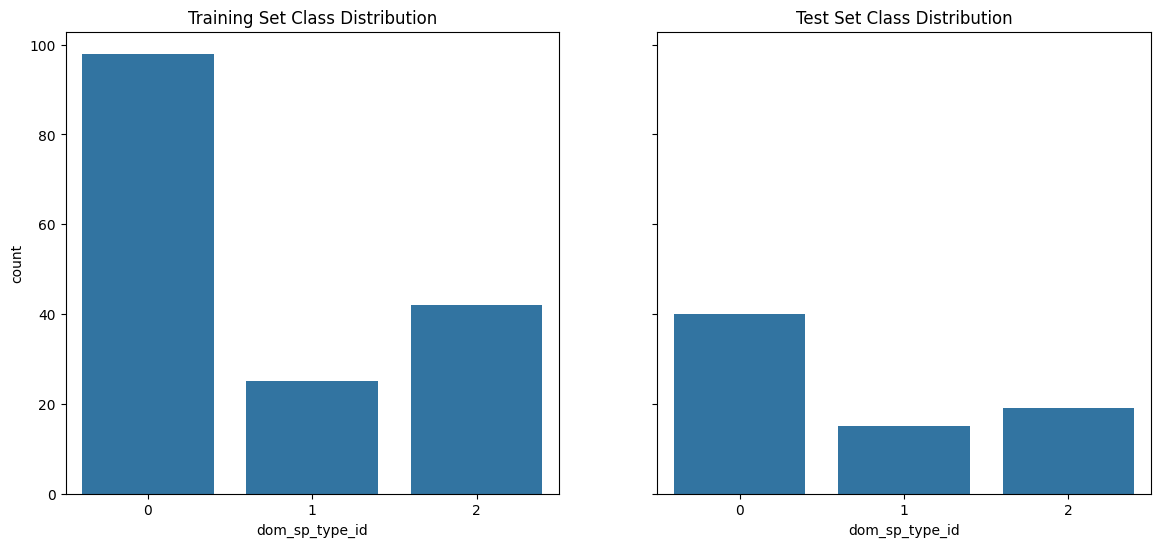

In [19]:
# Split data into train and test sets (combine val into test since not needed as seperate for RF)
train_df = df[df['split'] == 'train'].reset_index(drop=True)
test_df = df[df['split'].isin(('val', 'test'))].reset_index(drop=True)

# Create histograms showing each dataset class distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
sns.countplot(x=f'{target_var}_id', data=train_df, ax=axes[0])
axes[0].set_title('Training Set Class Distribution')
sns.countplot(x=f'{target_var}_id', data=test_df, ax=axes[1])
axes[1].set_title('Test Set Class Distribution')


plt.show()

Accuracy: 0.69
Kappa: 0.47


<Axes: >

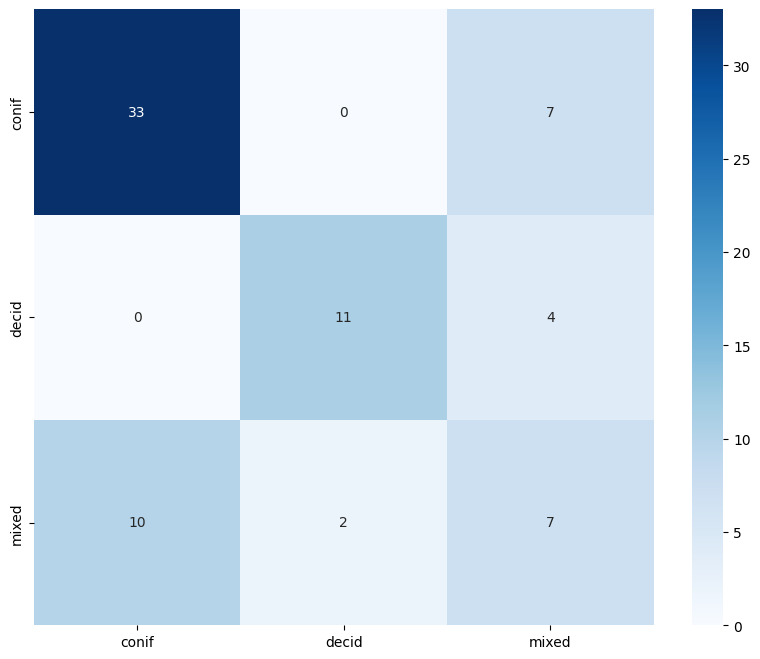

In [20]:
rf = RandomForestClassifier(n_estimators=100, random_state=25)

rf.fit(train_df[als_metrics_nms], train_df[f'{target_var}_id'])

# Apply the model to the test set
test_df['pred_dom_sp_group_id'] = rf.predict(test_df[als_metrics_nms])

# Calculate accuracy and kappa
accuracy = accuracy_score(test_df[f'{target_var}_id'], test_df['pred_dom_sp_group_id'])
kappa = cohen_kappa_score(test_df[f'{target_var}_id'], test_df['pred_dom_sp_group_id'])

print(f"Accuracy: {accuracy:.2f}")
print(f"Kappa: {kappa:.2f}")

# Print confusion matrix

conf_matrix = confusion_matrix(test_df[f'{target_var}_id'], test_df['pred_dom_sp_group_id'])

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=dom_sp_dict.values(),
            yticklabels=dom_sp_dict.values())